In [1]:
import numpy as np

from devito.logger import info
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import Model, PointSource, Receiver
from devito import clear_cache, TimeFunction, Operator, Function
from devito.logger import set_log_level
from sympy import Eq, solve, cos, sin, sqrt,exp, diff
from opescibench import LinePlotter

import matplotlib.pyplot as plt
from matplotlib import cm

In [63]:

class ModelBench(Model):
    """
    Physical model used for accuracy benchmarking,
    all is the same as a model except the critical dt
    made small enough to ignore
    time discretization errors
    """

    @property
    def critical_dt(self):
        """Critical computational time step value from the CFL condition."""
        # For a fixed time order this number goes down as the space order increases.
        #
        # The CFL condtion is then given by
        # dt <= coeff * h / (max(velocity))
        coeff = 0.38 if len(self.shape) == 3 else 0.42
        return .001*self.spacing[0]

# Manufacture solution

https://arxiv.org/pdf/1702.01383.pdf

x/sqrt(x)*exp(-(pi f0) (r(x,z) - at)^2) - exp(-(pi f0) (r(x,z) - a2 t)^2)

In [92]:
def d1(xx, size, order):
    roots = np.linspace(-1., 2., order)
#     return 1e-3*xx*(size-xx)
    return np.prod([(xx/size - r) for r in roots])

def mms(h, nn, order, nt):
    clear_cache()
    set_log_level("ERROR")

    modelloc = ModelBench(vp=1., origin=(0., 0.), spacing=(h, h), shape=(nn, nn), nbpml=spc, dtype=np.float64)
    dt = modelloc.critical_dt

    # Create symbols for forward wavefield, source and receivers
    u = TimeFunction(name='u', grid=modelloc.grid, save=nt,
                     time_order=2, space_order=spc)
    anlytic = TimeFunction(name='anlytic', grid=modelloc.grid, space_order=spc, save=nt)

    s = modelloc.grid.stepping_dim.spacing
    x, y = modelloc.grid.dimensions
    sol = 1e6*(d1(x, modelloc.shape_domain[0], 5) *
               d1(y, modelloc.shape_domain[1], 7) *
               sin(2.0* np.pi * modelloc.grid.time_dim*s/nt))
    source_term = (diff(sol, modelloc.grid.time_dim, 2) -
                   diff(sol, modelloc.grid.dimensions[0], 2) -
                   diff(sol, modelloc.grid.dimensions[1], 2))

    stencil = [Eq(u.forward, 2.0 * u - u.backward + s**2 * u.laplace + s**2 * source_term)]
    analytical = [Eq(anlytic, sol)]
    init_0 = [Eq(u.indexed[0, x, y], sol.subs({modelloc.grid.time_dim : 0}))]
    init_1 = [Eq(u.indexed[1, x, y], sol.subs({modelloc.grid.time_dim : 1}))]

    op = Operator(init_0 + init_1 + stencil + analytical, dse='noop', dle='noop')
    summary = op.apply(dt=dt, time_s=0)
    return u, anlytic, summary

# Verification

We compute the error between the numerical and analytical solutions for varying spatial discretization order and grid spacing. We also compare the time to solution to the erro for these parameters.

In [59]:

# sizes = ((401 , 1.0), (251, .16), (201, .5), (101, .25), (51, .125))
orders = [2, 4, 6, 8 ,10]



orders = ((2, ((401 , 2.0), (251, 3.2), (201, 4.0))),
           (4, ((251, 3.2), (201, 4.0), (101, 8.0))),
           (8, ((201, 4.0), (101, 8.0), (51, 16.0))))
errorl2 = np.zeros((3, 3))
timing = np.zeros((3, 3))

# set_log_level("ERROR")

nt = 500

ind_o = -1
for spc, gr in orders:
    ind_o +=1
    ind_spc = -1
    for nn, h in gr:
        ind_spc += 1
        u, analytical, summary = mms(h, nn, spc, nt)
        errorl2[ind_o, ind_spc] = np.linalg.norm(u.data[nt-1, spc:-spc, spc:-spc] -
                                                 analytical.data[nt-1, spc:-spc, spc:-spc])
        timing[ind_o, ind_spc] = summary.timings['main']
        print("starting space order %s with (%s, %s) grid points the error is %s for %s runtime" %
              (spc, nn, nn, errorl2[ind_o, ind_spc], timing[ind_o, ind_spc]))
        
        
        

starting space order 2 with (401, 401) grid points the error is 121.094183888 for 9.547691 runtime
starting space order 2 with (251, 251) grid points the error is 142.530024886 for 3.813124 runtime
starting space order 2 with (201, 201) grid points the error is 145.606949189 for 2.23597 runtime
starting space order 4 with (251, 251) grid points the error is 142.342019909 for 4.338777 runtime
starting space order 4 with (201, 201) grid points the error is 145.657772433 for 2.492737 runtime
starting space order 4 with (101, 101) grid points the error is 136.848326015 for 0.679849 runtime
starting space order 8 with (201, 201) grid points the error is 146.113955578 for 2.928494 runtime
starting space order 8 with (101, 101) grid points the error is 139.498227014 for 0.761027 runtime
starting space order 8 with (51, 51) grid points the error is 112.270355511 for 0.214442 runtime


In [43]:
stylel = ('-^k', '-^b', '-^r', '-^g', '-^c')

ord = [2, 4, 8]

dx = [2, 3.2, 4, 8, 16]
with LinePlotter(figname='MyPrettyPicture.pdf', plotdir='./',  xlabel='error') as plot:
    for i in range(0, 3):
        plot.add_line(list(errorl2[:, i]), list(timing[:, i]), label=('order %s' % ord[i]), style=stylel[i],
                      annotations=[('dx = %s m' % (sc)) for sc in dx][i:i+3])

plt.clf()
from IPython.display import IFrame
IFrame("MyPrettyPicture.pdf", width=600, height=600)

OpesciBench: Plotting ./MyPrettyPicture.pdf 


In [37]:
print(timing)

[[ 1.675505  0.784202  0.446465]
 [ 0.792116  0.445195  0.128111]
 [ 0.51815   0.151633  0.043194]]


In [38]:
print(errorl2)

[[  6.73106275e-06   3.07255159e-05   5.86849575e-05]
 [  2.98323310e-05   5.67200929e-05   3.07468408e-04]
 [  5.31287004e-05   2.83690501e-04   7.94054295e-04]]


In [ ]:
stylel = ('-^k', '-^b', '-^r', '-^g', '-^c')
style2 = ('--k', '--b', '--r', '--g', '--c')

with LinePlotter(figname='MyPrettyPicture3.pdf', plotdir='./',  xlabel='Grid size', ylabel = 'L2 error') as plot:
    for i in range(0, len(orders)):
        theory = [k**(orders[i]) for k in [2, 4, 6]][::-1]
        theory = [errorl2[-1,i]*th/theory[0] for th in theory]
        plot.add_line([sc for _, sc in sizes][::-1], list(errorl2[::-1, i]), label=('order %s' % orders[i]),
                      annotations=[('dx = %s m' % (sc)) for _, sc in sizes][::-1], style=stylel[i])
        plot.add_line([sc for _, sc in sizes][::-1], list(theory), style=style2[i])
plt.clf()
from IPython.display import IFrame
IFrame("MyPrettyPicture3.pdf", width=600, height=600)

In [93]:
u1, analy1, _ = mms(.25, 201, 2, nt)
u2, analy2, _ = mms(.25, 201, 8, nt)

# Plot

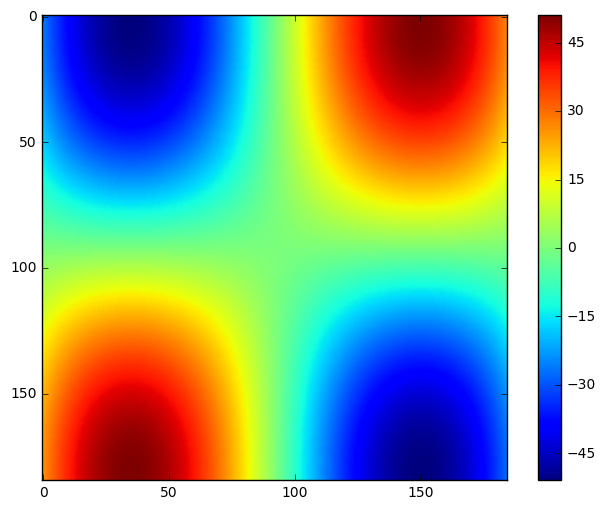

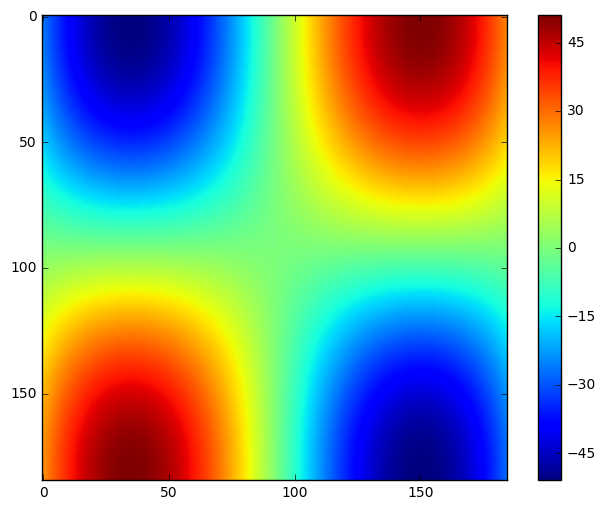

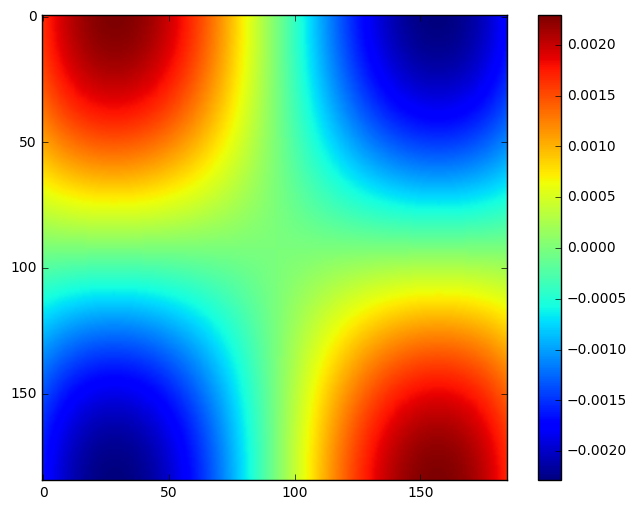

In [94]:
ti=nt-1
plt.figure()
plt.imshow(u1.data[ti, 2*spc:-2*spc, 2*spc:-2*spc])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(analy1.data[ti, 2*spc:-2*spc, 2*spc:-2*spc])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(u1.data[ti, 2*spc:-2*spc, 2*spc:-2*spc] - analy1.data[ti, 2*spc:-2*spc, 2*spc:-2*spc])
plt.colorbar()
plt.show()

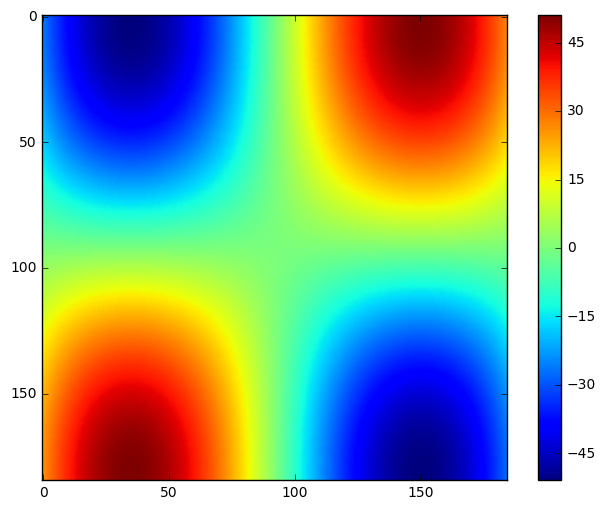

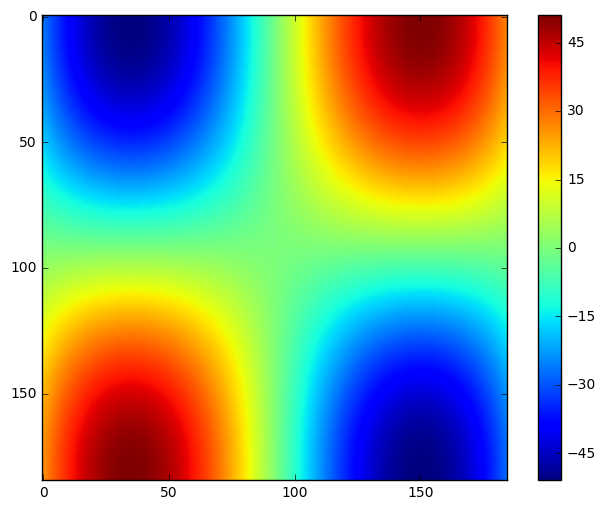

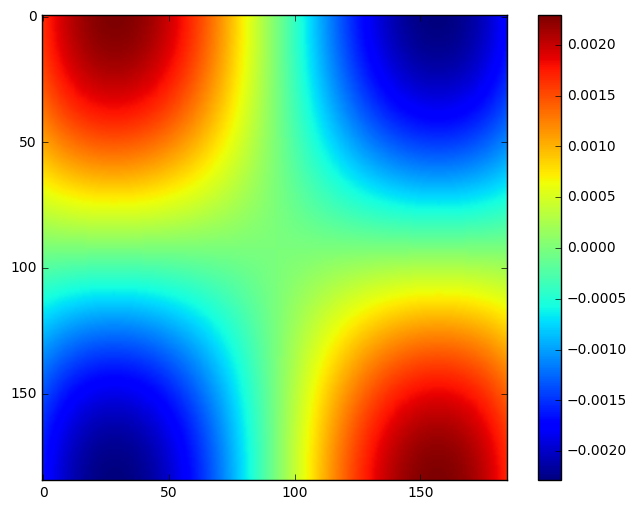

In [95]:
ti=nt-1
plt.figure()
plt.imshow(u2.data[ti, 2*spc:-2*spc, 2*spc:-2*spc])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(analy2.data[ti, 2*spc:-2*spc, 2*spc:-2*spc])
plt.colorbar()
plt.show()
plt.figure()
plt.imshow(u2.data[ti, 2*spc:-2*spc, 2*spc:-2*spc] - analy2.data[ti, 2*spc:-2*spc, 2*spc:-2*spc])
plt.colorbar()
plt.show()

In [ ]:
def d1(xx, order):
    sol = np.zeros(xx.shape)
    roots = np.linspace(0., 1., order)
    return [np.prod([(xloc/nn - r) for r in roots])*np.sin(xloc/order) for xloc in xx]
plt.figure()
plt.plot(d1(np.linspace(0, nn, nn), 5))
plt.show()